<a href="https://colab.research.google.com/github/jon-chun/GenAI-Multi-Agent-Networks-and-Digital-Twins/blob/main/code/notebooks/sentimentarcs_supersimplified_20241111.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>


# SentimentArcs Simplified Notebook

Created:

* 28 Oct 2022
* Jon Chun

A simplified version of SentimentArcs Notebooks with only the most common and state-of-the-art sentiment analysis models in the ensemble. This operationalizes SentimentArcs more accessible and robust.

* https://github.com/jon-chun/sentimentarcs_notebooks

* https://arxiv.org/pdf/2110.09454.pdf

In [1]:
%whos

Interactive namespace is empty.


# **PRE-REQUISITES**

## INPUT Text File
- name: format 'book_{title-words}_{author}.txt'
-- eg book_animal-farm_gorwell.txt
-- eg book_the-great-gatsby_fscottfitzgerald.txt
- content: cleaned plain text

## API Keys Necessary
- huggingface.co ('HF_TOKEN')
- wandb.com ('WANDB_TOKEN')



# Setup

## Install Libraries

In [2]:
# !pip install transformers[sentencepiece]

!pip install transformers

In [3]:
# May require [RESET RUNTIME]

# !pip install modin[all]

## Import Libraries

In [4]:
from google.colab import files

In [5]:
import numpy as np
import pandas as pd
# import modin.pandas as pd_modin
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks, argrelextrema
from statsmodels.nonparametric.smoothers_lowess import lowess
import textwrap

import datetime
import re
import os

from tqdm import tqdm
import tqdm.notebook as tq
# for i in tq.tqdm(...):

## Configure Settings

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Global Variables & Functions

## Global Variables

In [7]:
# Main (Modin) DataFrame for Novel Sentiments

sentiment_df = pd.DataFrame


## Common Functions

In [8]:
def verify_novel(novel_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Name: {novel_name_str}')
  print(f'  Char Len: {len(novel_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {novel_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {novel_str[-index_ends:]}\n\n')

In [9]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [53]:
def save_plot2png(file_suffix='_plot.png', nodate=True, base_filename='plot'):
    '''
    Save the current plot to a PNG file.

    INPUT:
    - file_suffix: The suffix to add to the output PNG filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.
    - base_filename: The base filename to use (defaults to "plot" if unspecified).

    OUTPUT:
    - Saves the current plot to a PNG file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = base_filename + file_suffix
    else:
        out_filename = base_filename + '_' + datetime_str + file_suffix

    # Save the plot
    plt.savefig(out_filename)
    print(f'STEP 1. Saving plot to temporary VM file: {out_filename}\n')

    # Download the saved file
    print(f'STEP 2. Downloading permanent copy of the PNG file: {out_filename}\n')
    files.download(out_filename)

In [57]:
def save_df2csv_and_download(df, file_suffix='_data.csv', nodate=True, base_filename='data'):
    '''
    Save the DataFrame to a CSV file.

    INPUT:
    - df: The DataFrame to save.
    - file_suffix: The suffix to add to the output CSV filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.
    - base_filename: The base filename to use (defaults to "data" if unspecified).

    OUTPUT:
    - Saves the DataFrame to a CSV file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = base_filename + file_suffix
    else:
        out_filename = base_filename + '_' + datetime_str + file_suffix

    # Save the DataFrame to CSV
    df.to_csv(out_filename, index=False)
    print(f'STEP 1. Saving DataFrame to temporary VM CSV file: {out_filename}\n')

    # Download the saved CSV file
    print(f'STEP 2. Downloading permanent copy of the CSV file: {out_filename}\n')
    files.download(out_filename)

# Get Clean Text

## Upload Trimmed Gutenberg Text (no header/footer)

Get plain text of familiar novel at:
* https://gutenberg.net.au/ (AUS)
* https://gutenberg.org/ (US)

In [12]:
# Upload Plain Text File
novel_name_str = ''
uploaded = files.upload()

# Allows for multiple file uploads, will only process the last
# Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    novel_name_str = fn

# Extract from Dict and decode binary into char string
TEXT_ENCODING = 'utf-8'  # Define the encoding format
novel_raw_str = uploaded[novel_name_str].decode(TEXT_ENCODING)

BOOK_FILENAME_AUTHOR = novel_name_str.split('.')[0]
BOOK_FILENAME_AUTHOR

Saving book_the-great-gatsby_fsfitzgerald.txt to book_the-great-gatsby_fsfitzgerald.txt
User uploaded file "book_the-great-gatsby_fsfitzgerald.txt" with length 286442 bytes


'book_the-great-gatsby_fsfitzgerald'

In [25]:
# Verify

verify_novel(novel_raw_str)

Novel Name: book_the-great-gatsby_fsfitzgerald.txt
  Char Len: 276892

Beginning:

                               Once again
                                  to
                                 Zelda


  Then wear the gold hat, if that will move her;
  If you can bounce high, bounce for her too,
  Till she cry “Lover, gold-hatted, high-bouncing lover,
  I must have you!”

  Thomas Parke d’Invilliers


                                  I

In my younger and more vulnerable years my father gave me some advice
that I’ve been turning over in my mind ever since.

“



------------------------------------
Ending:

 hardly fail to grasp it. He
did not know that it was already behind him, somewhere back in that
vast obscurity beyond the city, where the dark fields of the republic
rolled on under the night.

Gatsby believed in the green light, the orgastic future that year by
year recedes before us. It eluded us then, but that’s no
matter—tomorrow we will run faster, stretch out our arms furthe

## Clean Text

In [26]:
!pip install clean-text

In [27]:
!pip install unidecode  # clean-text dependency

In [28]:
from cleantext import clean

In [29]:
novel_clean_str = clean(novel_raw_str,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    # replace_with_punct="",          # instead of removing punctuations you may replace them
    # replace_with_url="<URL>",
    # replace_with_email="<EMAIL>",
    # replace_with_phone_number="<PHONE>",
    # replace_with_number="<NUMBER>",
    # replace_with_digit="0",
    # replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

# Replace all new lines/returns with single whitespace
novel_clean_str = novel_clean_str.replace('\n\r', ' ')
novel_clean_str = novel_clean_str.replace('\n', ' ')
novel_clean_str = novel_clean_str.replace('\r', ' ')
novel_clean_str = ' '.join(novel_clean_str.split())
novel_clean_str

'once again to zelda then wear the gold hat, if that will move her; if you can bounce high, bounce for her too, till she cry "lover, gold-hatted, high-bouncing lover, i must have you!" thomas parke d\'invilliers i in my younger and more vulnerable years my father gave me some advice that i\'ve been turning over in my mind ever since. "whenever you feel like criticizing anyone," he told me, "just remember that all the people in this world haven\'t had the advantages that you\'ve had." he didn\'t say any more, but we\'ve always been unusually communicative in a reserved way, and i understood that he meant a great deal more than that. in consequence, i\'m inclined to reserve all judgements, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores. the abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and so it came about that in college i was unjustly accused of being a politician, bec

In [30]:
# Verify

verify_novel(novel_clean_str, index_ends=500)

Novel Name: book_the-great-gatsby_fsfitzgerald.txt
  Char Len: 268671

Beginning:

 once again to zelda then wear the gold hat, if that will move her; if you can bounce high, bounce for her too, till she cry "lover, gold-hatted, high-bouncing lover, i must have you!" thomas parke d'invilliers i in my younger and more vulnerable years my father gave me some advice that i've been turning over in my mind ever since. "whenever you feel like criticizing anyone," he told me, "just remember that all the people in this world haven't had the advantages that you've had." he didn't say an



------------------------------------
Ending:

 he could hardly fail to grasp it. he did not know that it was already behind him, somewhere back in that vast obscurity beyond the city, where the dark fields of the republic rolled on under the night. gatsby believed in the green light, the orgastic future that year by year recedes before us. it eluded us then, but that's no matter--tomorrow we will run faster, 

## Trim Text

In [31]:
# FUTURE: Auto trim Gutenberg HEADER and FOOTER (varies too much)

novel_trim_str = novel_clean_str

## Segment Text

In [32]:
!pip install pysbd  # Python Sentence Boundry Detection

In [33]:
import pysbd

In [34]:
# FIX: Normally assigned within the 'Trim Header & Footer' Section

# Ensure we have trimmed version of novel in novel_trim_str

if len(novel_trim_str) > 0:
  # Header/Footer already trimmed from body of Novel
  pass
else:
  novel_trim_str = novel_raw_str

In [35]:
%%time

# NOTE:  1m05s animal farm
#       11m22s harry potter
#        2m13s jane eyre

# Split Novel into Segments (~Sentences)
seg = pysbd.Segmenter(language="en", clean=False)
# novel_segments_ls = seg.segment(novel_trim_str)
novel_segments_ls = [segment for segment in tqdm(seg.segment(novel_trim_str), desc="Segmenting Novel")]

Segmenting Novel: 100%|██████████| 1357/1357 [00:00<00:00, 1053038.03it/s]

CPU times: user 40 s, sys: 144 ms, total: 40.1 s
Wall time: 1min 1s


In [36]:
# Trim any leading/trailing whitespace on all Sentences

novel_clean_ls = [x.strip() for x in novel_segments_ls]

In [37]:
# Verify

verify_novel(novel_clean_ls, 10)

Novel Name: book_the-great-gatsby_fsfitzgerald.txt
  Char Len: 1357

Beginning:

 ['once again to zelda then wear the gold hat, if that will move her; if you can bounce high, bounce for her too, till she cry "lover, gold-hatted, high-bouncing lover, i must have you!" thomas parke d\'invilliers i in my younger and more vulnerable years my father gave me some advice that i\'ve been turning over in my mind ever since.', '"whenever you feel like criticizing anyone," he told me, "just remember that all the people in this world haven\'t had the advantages that you\'ve had." he didn\'t say any more, but we\'ve always been unusually communicative in a reserved way, and i understood that he meant a great deal more than that.', "in consequence, i'm inclined to reserve all judgements, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores.", 'the abnormal mind is quick to detect and attach itself to this quality when it appears in a normal per

In [38]:
# Save to file and download copy

save_text2txt_and_download(novel_clean_ls, '_segments.txt')

STEP 1. Processing List of Strings Object

STEP 2. Saving textfile to temporary VM file: book_the-great-gatsby_fsfitzgerald_segments.txt

STEP 3. Downloading permanent copy of textfile: book_the-great-gatsby_fsfitzgerald_segments.txt



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
sentiment_df

pandas.core.frame.DataFrame

In [40]:
# Populate novel sentiment_df with sentence number and clean segmented strings

sentence_no_ls = list(range(len(novel_clean_ls)))
sentence_no_ls[-1]

sentiment_df = pd.DataFrame({'line_no':sentence_no_ls, 'line':novel_clean_ls})
sentiment_df.head()

1356

,line_no,line
0,0,"once again to zelda then wear the gold hat, if..."
1,1,"""whenever you feel like criticizing anyone,"" h..."
2,2,"in consequence, i'm inclined to reserve all ju..."
3,3,the abnormal mind is quick to detect and attac...
4,4,most of the confidences were unsought--frequen...


# Compute Sentiment

## STEP (1): Symbolic: Lexicons

### VADER

In [41]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.0 MB/s eta 0:00:00


In [162]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

In [221]:
sentiment_vader_ls = [sid_obj.polarity_scores(asentence)['compound'] for asentence in novel_clean_ls]

In [222]:
# Create new VADER DataFrame to save results

vader_df = sentiment_df[['line_no', 'line']].copy(deep=True)
vader_df['vader'] = pd.Series(sentiment_vader_ls)
vader_df.head()

,line_no,line,vader
0,0,"once again to zelda then wear the gold hat, if...",0.5572
1,1,"""whenever you feel like criticizing anyone,"" h...",0.7265
2,2,"in consequence, i'm inclined to reserve all ju...",-0.2732
3,3,the abnormal mind is quick to detect and attac...,-0.2960
4,4,most of the confidences were unsought--frequen...,0.3797


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'VADER Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: vader_sentiment_vader_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: vader_sentiment_vader_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

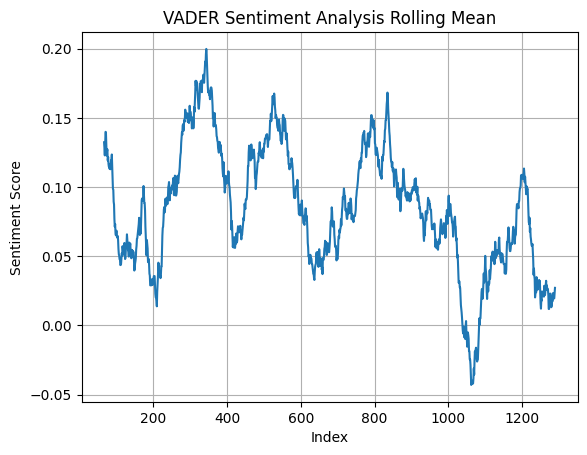

In [223]:
win_per = 0.1
win_size = int(win_per * vader_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'sentiment' column
_ = vader_df['vader'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("VADER Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_vader_sentiment_plot.png', nodate=True, base_filename='vader_sentiment')

plt.show()

# Close the plot to free up memory
plt.close()

In [224]:
# Call the function to save the DataFrame to CSV
save_df2csv_and_download(vader_df, '_vader_sentiment.csv', nodate=True, base_filename=BOOK_FILENAME_AUTHOR)

STEP 1. Saving DataFrame to temporary VM CSV file: book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TextBlob

In [47]:
from textblob import TextBlob

In [48]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [225]:
sentiment_textblob_ls = [TextBlob(asentence).sentiment.polarity for asentence in novel_clean_ls]
# sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [226]:
# Create new TextBlob DataFrame to save results

textblob_df = sentiment_df[['line_no', 'line']].copy(deep=True)
textblob_df['textblob'] = pd.Series(sentiment_textblob_ls)
textblob_df.head()

,line_no,line,textblob
0,0,"once again to zelda then wear the gold hat, if...",0.050000
1,1,"""whenever you feel like criticizing anyone,"" h...",0.500000
2,2,"in consequence, i'm inclined to reserve all ju...",0.085000
3,3,the abnormal mind is quick to detect and attac...,0.016667
4,4,most of the confidences were unsought--frequen...,-0.050744


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'TextBlob Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: textblob_sentiment_textblob_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: textblob_sentiment_textblob_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

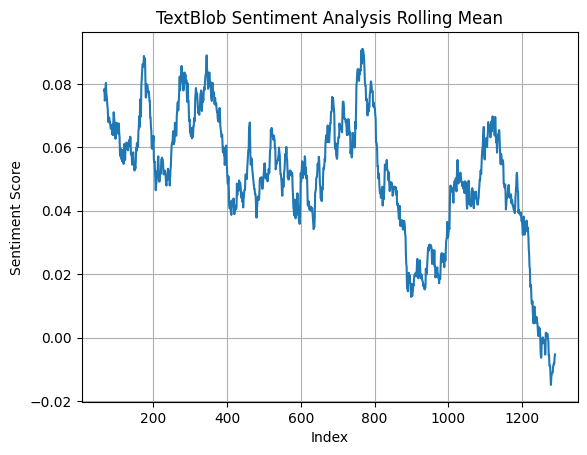

In [227]:
win_per = 0.1
win_size = int(win_per * textblob_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'sentiment' column
_ = textblob_df['textblob'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("TextBlob Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_textblob_sentiment_plot.png', nodate=True, base_filename='textblob_sentiment')

plt.show()

# Close the plot to free up memory
plt.close()


In [228]:
###CODE_5:
# Save TextBlob Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(textblob_df, '_textblob_sentiment.csv', nodate=True, base_filename=BOOK_FILENAME_AUTHOR)

STEP 1. Saving DataFrame to temporary VM CSV file: book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## STEP (2): Connectionist: Transformers

**WARNING:** This takes a LONG TIME to run to completion (~45mins).

Accelerate Large Models:

* https://ponder.io/faster-hugging-face-with-modin/ ***

* https://huggingface.co/blog/accelerate-large-models

* (Moden) https://github.com/modin-project/modin
* (Moden+HF) https://github.com/ponder-org/ponder-blog/blob/main/Modin%20%2B%20Hugging%20Face%20Tutorial.ipynb

* https://heartbeat.comet.ml/optimizing-a-huggingface-transformer-model-for-toxic-speech-detection-6d59e66f615a

In [61]:
!pip install -q transformers

In [62]:
!pip install sentencepiece

In [63]:
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import AutoModelForSeq2SeqLM, AutoModelWithLMHead

from transformers import BertTokenizer, BertForSequenceClassification

import sentencepiece

In [64]:
from transformers import TrainingArguments

In [65]:
# Test Dataset: List of TestSentiment Strings

test_lines_ls = [
    "I love you.",
    "You hate me.",
    "I'm not sure if I hate you, but I certainly don't care for your attitude young man!"
]

In [125]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

### HF: DistilBERT Finetuned (sst2en)

distilbert-base-uncased-finetuned-sst-2-english

* https://huggingface.co/docs/transformers/task_summary

In [171]:
# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [172]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [173]:
# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [174]:
# import wandb

# wandb.init() # wandb.log()

In [175]:
%%time

# NOTE: Must click on output LINK, get wandb API_KEY, and paste it in text input box

# NOTE: 0m40s 02:49EST on 28Oct2022 Colab Pro (The Idiot)


# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 18.8 s, sys: 86 ms, total: 18.9 s
Wall time: 21.8 s


In [176]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [177]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [178]:
line_no_ls = list(range(len(sentiment_ls)))

In [179]:
# Create DataFrame with texts, predictions, labels, and scores
distilbert_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','distilbert','label','score'])
distilbert_df.head()

,line_no,line,distilbert,label,score
0,0,"once again to zelda then wear the gold hat, if...",1,POSITIVE,0.995641
1,1,"""whenever you feel like criticizing anyone,"" h...",1,POSITIVE,0.960773
2,2,"in consequence, i'm inclined to reserve all ju...",1,POSITIVE,0.920143
3,3,the abnormal mind is quick to detect and attac...,0,NEGATIVE,0.988105
4,4,most of the confidences were unsought--frequen...,0,NEGATIVE,0.951712


In [180]:
distilbert_df['label'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'DistilBERT Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: distilbert_sentiment_distilbert_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: distilbert_sentiment_distilbert_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

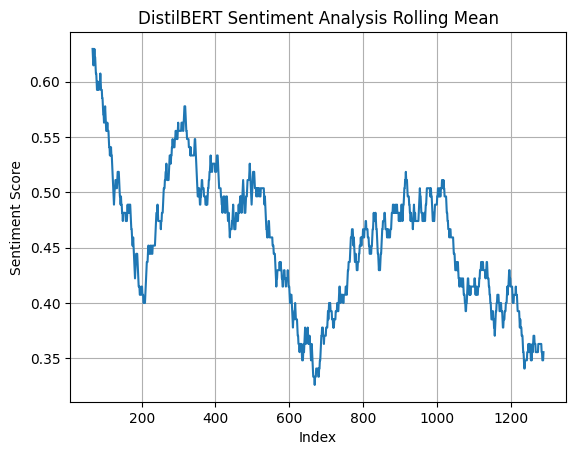

In [181]:
win_per = 0.1
win_size = int(win_per * distilbert_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'distilbert' sentiment column
_ = distilbert_df['distilbert'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("DistilBERT Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_distilbert_sentiment_plot.png', nodate=True, base_filename='distilbert_sentiment')

plt.show()

# Close the plot to free up memory
plt.close()


In [182]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(distilbert_df, '_distilbert_sentiment.csv', nodate=True, base_filename=BOOK_FILENAME_AUTHOR)


STEP 1. Saving DataFrame to temporary VM CSV file: book_the-great-gatsby_fsfitzgerald_distilbert_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: book_the-great-gatsby_fsfitzgerald_distilbert_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### HF: MultiBERT NLPTown

nlptown/bert-base-multilingual-uncased-sentiment

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=I+like+you.+I+love+you

In [183]:
# Load tokenizer and model, create trainer

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [184]:
# Tokenize texts and create prediction data set

# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [185]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [186]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [187]:
%%time

# NOTE:  4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#        1m28s 01:24EST on 28Oct2022 Colab Pro (The Idiot)
#        1m27s 02:42EST on 28Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 33 s, sys: 171 ms, total: 33.2 s
Wall time: 38.2 s


In [188]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [189]:
line_no_ls = list(range(len(sentiment_ls)))

In [190]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(line_no_ls,line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','nlptown','label','score'])
nlptown_df.head()

,line_no,line,nlptown,label,score
0,0,"once again to zelda then wear the gold hat, if...",4,5 stars,0.475255
1,1,"""whenever you feel like criticizing anyone,"" h...",4,5 stars,0.297071
2,2,"in consequence, i'm inclined to reserve all ju...",1,2 stars,0.367582
3,3,the abnormal mind is quick to detect and attac...,2,3 stars,0.314100
4,4,most of the confidences were unsought--frequen...,1,2 stars,0.524769


In [191]:
nlptown_df.shape

(1357, 5)

In [192]:
nlptown_df['label'].unique()

array(['5 stars', '2 stars', '3 stars', '4 stars', '1 star'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'NLPTown Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: nlptown_sentiment_nlptown_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: nlptown_sentiment_nlptown_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

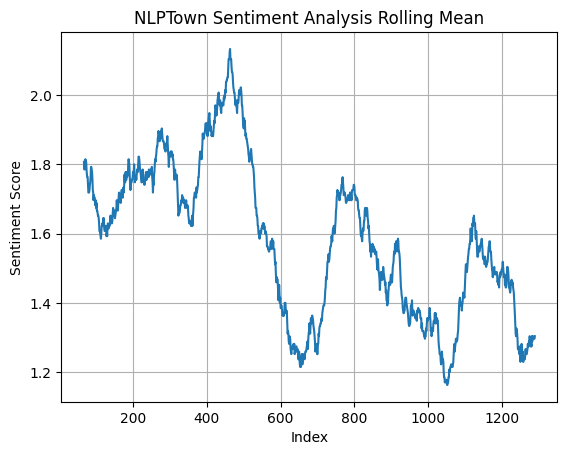

In [193]:
###CODE_7:
win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'nlptown' sentiment column
_ = nlptown_df['nlptown'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("NLPTown Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_nlptown_sentiment_plot.png', nodate=True, base_filename='nlptown_sentiment')

plt.show()

# Close the plot to free up memory
plt.close()

In [194]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(nlptown_df, '_nlptown_sentiment.csv', nodate=True, base_filename=BOOK_FILENAME_AUTHOR)


STEP 1. Saving DataFrame to temporary VM CSV file: book_the-great-gatsby_fsfitzgerald_nlptown_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: book_the-great-gatsby_fsfitzgerald_nlptown_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### HF: RoBERTa Finetuned (en)

siebert/sentiment-roberta-large-english

* https://colab.research.google.com/github/chrsiebert/sentiment-roberta-large-english/blob/main/sentiment_roberta_prediction_example.ipynb

In [195]:
# Load tokenizer and model, create trainer

model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [196]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [197]:
# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [198]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#       4m18s 02:27EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 2min 5s, sys: 279 ms, total: 2min 5s
Wall time: 2min 6s


In [199]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [200]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [201]:
line_no_ls = list(range(len(sentiment_ls)))

In [202]:
# Create DataFrame with texts, predictions, labels, and scores
roberta15lg_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','roberta15lg','label','score'])
roberta15lg_df.head()

,line_no,line,roberta15lg,label,score
0,0,"once again to zelda then wear the gold hat, if...",1,POSITIVE,0.995791
1,1,"""whenever you feel like criticizing anyone,"" h...",1,POSITIVE,0.997030
2,2,"in consequence, i'm inclined to reserve all ju...",1,POSITIVE,0.991612
3,3,the abnormal mind is quick to detect and attac...,0,NEGATIVE,0.990941
4,4,most of the confidences were unsought--frequen...,0,NEGATIVE,0.989568


In [203]:
roberta15lg_df['label'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'RoBERTa Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: roberta15lg_sentiment_roberta15lg_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: roberta15lg_sentiment_roberta15lg_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

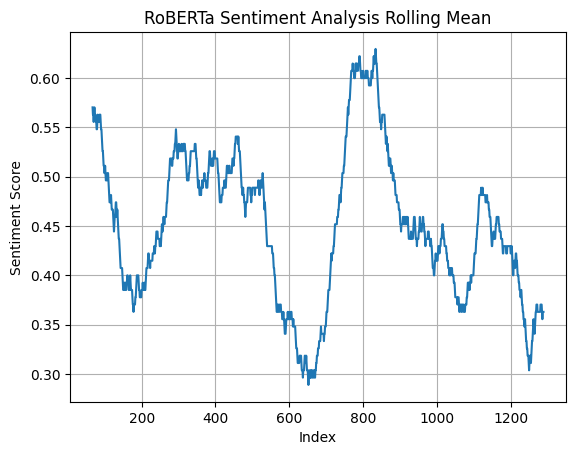

In [204]:
win_per = 0.1
win_size = int(win_per * roberta15lg_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'roberta15lg' sentiment column
_ = roberta15lg_df['roberta15lg'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("RoBERTa Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_roberta15lg_sentiment_plot.png', nodate=True, base_filename='roberta15lg_sentiment')

plt.show()

# Close the plot to free up memory
plt.close()


In [206]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(roberta15lg_df, '_roberta15lg_sentiment.csv', nodate=True, base_filename=BOOK_FILENAME_AUTHOR)


STEP 1. Saving DataFrame to temporary VM CSV file: book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot

## Dialate SentimentR, Combine, and Plot Together

* VADER
* TextBlob
* SyuzhetR (4)
* DistilBERT
* NLPTown
* RoBERTa15lg

In [207]:
!ls -altr

total 3448
drwxr-xr-x 4 root root   4096 Nov  8 14:19 .config
drwxr-xr-x 1 root root   4096 Nov  8 14:19 sample_data
drwxr-xr-x 1 root root   4096 Nov 11 21:38 ..
-rw-r--r-- 1 root root 286442 Nov 11 21:41 book_the-great-gatsby_fsfitzgerald.txt
-rw-r--r-- 1 root root 268780 Nov 11 21:43 book_the-great-gatsby_fsfitzgerald_segments.txt
drwxr-xr-x 2 root root   4096 Nov 11 21:52 results
drwxr-xr-x 2 root root   4096 Nov 11 22:06 .ipynb_checkpoints
-rw-r--r-- 1 root root 288085 Nov 11 22:06 vader_sentiment_vader_sentiment.csv
-rw-r--r-- 1 root root 294438 Nov 11 22:06 textblob_sentiment_textblob_sentiment.csv
-rw-r--r-- 1 root root 308506 Nov 11 22:08 distilbert_sentiment_distilbert_sentiment.csv
-rw-r--r-- 1 root root 307161 Nov 11 22:10 nlptown_sentiment_nlptown_sentiment.csv
-rw-r--r-- 1 root root  45348 Nov 11 22:14 vader_sentiment_vader_sentiment_plot.png
-rw-r--r-- 1 root root 288085 Nov 11 22:14 book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv
-rw-r--r-- 1 root root  46485 Nov

In [208]:
def clean_filenames_with_max_n(substr_del_template=' ({n})'):
    # Regex pattern to match the substring pattern " ({n})" where n is any integer
    pattern = re.compile(r' \((\d+)\)')

    # Dictionary to store filenames with their highest "n" value
    files_to_keep = {}

    # Iterate over all files in the current directory
    for filename in os.listdir('.'):
        match = pattern.search(filename)
        if match:
            # Extract the number and the root filename (without the " (n)" part and the extension)
            n_value = int(match.group(1))
            root_filename = pattern.sub('', filename)
            file_extension = os.path.splitext(filename)[1]
            base_filename = root_filename + file_extension

            # Keep only the file with the highest "n" value for each base filename
            if base_filename not in files_to_keep or n_value > files_to_keep[base_filename][1]:
                files_to_keep[base_filename] = (filename, n_value)

    # Delete files that are not the one with the highest "n" value
    for filename in os.listdir('.'):
        match = pattern.search(filename)
        if match:
            n_value = int(match.group(1))
            root_filename = pattern.sub('', filename)
            file_extension = os.path.splitext(filename)[1]
            base_filename = root_filename + file_extension

            # If the current file is not the one to keep, delete it
            if filename != files_to_keep[base_filename][0]:
                print(f"Deleting file: {filename}")
                os.remove(filename)
            else:
                # Rename the kept file to remove the " (n)" part
                new_name = base_filename
                if filename != new_name:
                    print(f"Renaming {filename} to {new_name}")
                    os.rename(filename, new_name)

# Run the function
clean_filenames_with_max_n()


In [209]:
def make_csv_list(filename_root):
    # List of possible model names
    model_ls = ['vader', 'textblob', 'syuzhetr', 'sentimentr', 'distilbert', 'nlptown', 'roberta15lg']

    # Remove the file extension and extract the title_author part
    filename_without_ext = os.path.splitext(filename_root)[0]
    parts = filename_without_ext.split('_')
    title_author = '_'.join(parts[1:3])  # Get both parts of title_author (e.g., "the-great-gatsby_fscottfitzgerald")

    # Initialize an empty list to hold the found CSV files
    csv_list = []

    # Debugging information
    print(f"Looking for files with title_author: {title_author}")

    # Iterate through each model name and construct the expected filename
    for model_name in model_ls:
        # Construct the filename based on the pattern
        csv_filename = f'book_{title_author}_{model_name}_sentiment.csv'

        # Check if the file exists in the current directory
        if os.path.isfile(csv_filename):
            csv_list.append(csv_filename)
        else:
            print(f"File not found: {csv_filename}")

    return csv_list




In [105]:
# sentiment_all_df.

In [210]:
# NOTE: Your uploaded text files should have 3 parts separated by two '_' underscores
# "book" + "_" + "title-words-separated-by-hyphens" + "_" + "author" (where author is one word with only alphanumeric chars, no hypens or other punctuations)

# BOOK_FILENAME_AUTHOR = 'book_animal-farm_gorwell'
# BOOK_FILENAME_AUTHOR = 'book_harry-potter-and-the-order-of-the-phoenix_jkrowlings'
# BOOK_FILENAME_AUTHOR = 'book_jane-eyre_cbronte'
# BOOK_FILENAME_AUTHOR = novel_name_str
BOOK_FILENAME_AUTHOR

'book_the-great-gatsby_fsfitzgerald'

In [211]:
# Example usage
csv_list = make_csv_list(BOOK_FILENAME_AUTHOR)
print(csv_list)

Looking for files with title_author: the-great-gatsby_fsfitzgerald
File not found: book_the-great-gatsby_fsfitzgerald_syuzhetr_sentiment.csv
File not found: book_the-great-gatsby_fsfitzgerald_sentimentr_sentiment.csv
['book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv', 'book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv', 'book_the-great-gatsby_fsfitzgerald_distilbert_sentiment.csv', 'book_the-great-gatsby_fsfitzgerald_nlptown_sentiment.csv', 'book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment.csv']


In [212]:
models_sa_ls = make_csv_list(BOOK_FILENAME_AUTHOR)
for amodel in models_sa_ls:
  print(amodel)

Looking for files with title_author: the-great-gatsby_fsfitzgerald
File not found: book_the-great-gatsby_fsfitzgerald_syuzhetr_sentiment.csv
File not found: book_the-great-gatsby_fsfitzgerald_sentimentr_sentiment.csv
book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv
book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv
book_the-great-gatsby_fsfitzgerald_distilbert_sentiment.csv
book_the-great-gatsby_fsfitzgerald_nlptown_sentiment.csv
book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment.csv


In [109]:
# models_sa_ls.remove('book_the-great-gatsby_fscottfitzgerald_sentimentr.csv')

In [229]:
for amodel in models_sa_ls:
  print(f"\n\n{amodel}")
  temp_df = pd.read_csv(amodel)
  print(temp_df.columns)



book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv
Index(['line_no', 'line', 'vader'], dtype='object')


book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv
Index(['line_no', 'line', 'textblob'], dtype='object')


book_the-great-gatsby_fsfitzgerald_distilbert_sentiment.csv
Index(['line_no', 'line', 'distilbert', 'label', 'score'], dtype='object')


book_the-great-gatsby_fsfitzgerald_nlptown_sentiment.csv
Index(['line_no', 'line', 'nlptown', 'label', 'score'], dtype='object')


book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment.csv
Index(['line_no', 'line', 'roberta15lg', 'label', 'score'], dtype='object')


In [230]:
sentiment_all_df = pd.read_csv(models_sa_ls[0])  # Start with vader

for i, amodel in enumerate(models_sa_ls[1:]):
    model_name_str = amodel.split('.')[0].split('_')[-1].lower().strip()
    print(f'Model #{i}: {model_name_str}')

    one_model_df = pd.read_csv(amodel)
    print(f' Cols: {one_model_df.columns.to_list()}')

    # Special handling for sentimentr which has different structure
    if 'sentimentr' in model_name_str:
        # Add line_no as index+1 since sentimentr is missing it
        one_model_df['line_no'] = range(1, len(one_model_df) + 1)

    # Remove unnecessary columns
    cols_to_drop = ['line', 'label', 'score']
    for col in cols_to_drop:
        if col in one_model_df.columns:
            one_model_df.drop(columns=[col], inplace=True)

    # Rename sentiment column if it exists
    if 'sentiment' in one_model_df.columns:
        one_model_df.rename(columns={'sentiment': model_name_str}, inplace=True)

    # Merge on line_no
    sentiment_all_df = sentiment_all_df.merge(one_model_df, on='line_no')

Model #0: sentiment
 Cols: ['line_no', 'line', 'textblob']
Model #1: sentiment
 Cols: ['line_no', 'line', 'distilbert', 'label', 'score']
Model #2: sentiment
 Cols: ['line_no', 'line', 'nlptown', 'label', 'score']
Model #3: sentiment
 Cols: ['line_no', 'line', 'roberta15lg', 'label', 'score']


In [231]:
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      1357 non-null   int64  
 1   line         1357 non-null   object 
 2   vader        1357 non-null   float64
 3   textblob     1357 non-null   float64
 4   distilbert   1357 non-null   int64  
 5   nlptown      1357 non-null   int64  
 6   roberta15lg  1357 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 74.3+ KB


In [232]:
# prompt: for sentiment_all_df columns rename sentiment_x and sentiment_y to vader and textblob

sentiment_all_df.rename(columns={'sentiment_x': 'vader', 'sentiment_y': 'textblob'}, inplace=True)
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      1357 non-null   int64  
 1   line         1357 non-null   object 
 2   vader        1357 non-null   float64
 3   textblob     1357 non-null   float64
 4   distilbert   1357 non-null   int64  
 5   nlptown      1357 non-null   int64  
 6   roberta15lg  1357 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 74.3+ KB


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'SMA of Z-score Normalized Sentiment Scores')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

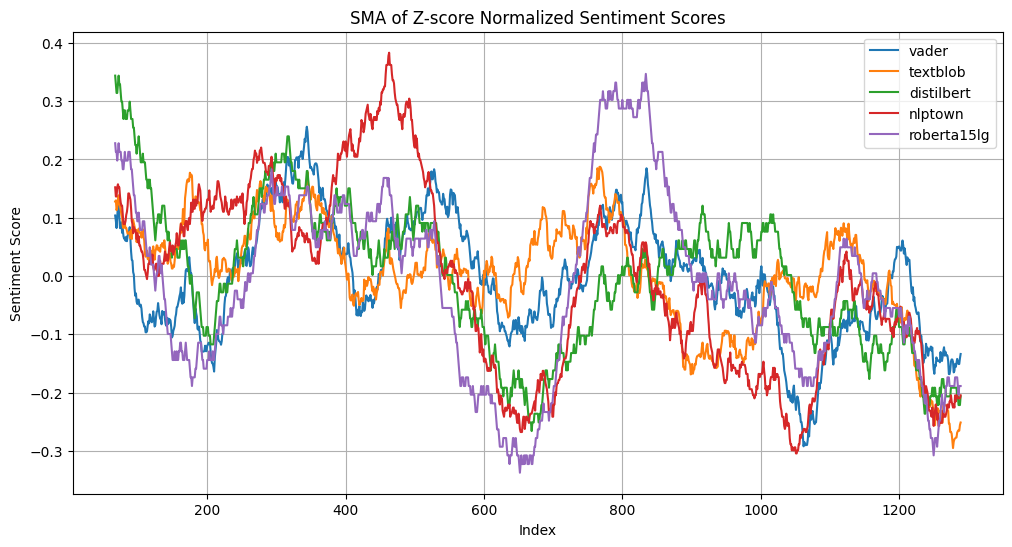

In [233]:
# prompt: on the same plot, first z-score normalize and then plot the sma (10% window) of vader, textblob, distilbert, nlptown, roberta15lg together

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Assuming sentiment_all_df is your DataFrame containing sentiment scores for different models
# and it has columns 'vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg'

# Z-score normalize the sentiment scores
for col in ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']:
  sentiment_all_df[col] = zscore(sentiment_all_df[col])

# Calculate the SMA (Simple Moving Average) with a 10% window for each model
win_per = 0.1
win_size = int(win_per * sentiment_all_df.shape[0])
for col in ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']:
  sentiment_all_df[f'{col}_sma'] = sentiment_all_df[col].rolling(win_size, center=True).mean()

# Plot the SMA of each model on the same plot
plt.figure(figsize=(12, 6))
for col in ['vader_sma', 'textblob_sma', 'distilbert_sma', 'nlptown_sma', 'roberta15lg_sma']:
  plt.plot(sentiment_all_df[col], label=col.replace('_sma', ''))

plt.title('SMA of Z-score Normalized Sentiment Scores')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

# Crux Detection and Extraction

## Smooth Plots and Add Crux Points

In [234]:
def get_sentiment_mean(df):
    """Same as before"""
    sentiment_cols = [col for col in df.columns
                     if col not in ['line', 'line_no']]
    return df[sentiment_cols].mean(axis=1).tolist()


def detect_peaks_valleys(smoothed_series, peak_algo='find_peaks', peak_algo_params=None):
    """
    Detect peaks and valleys using specified algorithm.

    Args:
        smoothed_series (list): Smoothed and normalized time series
        peak_algo (str): Peak detection algorithm ('find_peaks', 'relmax', 'threshold')
        peak_algo_params (dict): Parameters for the chosen algorithm

    Returns:
        dict: Dictionary with 'peaks' and 'valleys' indices
    """
    series = np.array(smoothed_series)

    # Default parameters for each algorithm
    default_params = {
        'find_peaks': {
            'distance': 20,
            'prominence': 0.1
        },
        'relmax': {
            'order': 10
        },
        'threshold': {
            'threshold': 0.5,
            'min_dist': 20
        }
    }

    params = peak_algo_params if peak_algo_params is not None else default_params[peak_algo]

    if peak_algo == 'find_peaks':
        peaks, _ = find_peaks(series,
                            distance=params['distance'],
                            prominence=params['prominence'])
        valleys, _ = find_peaks(-series,
                              distance=params['distance'],
                              prominence=params['prominence'])

    elif peak_algo == 'relmax':
        peaks = argrelextrema(series, np.greater,
                            order=params['order'])[0]
        valleys = argrelextrema(series, np.less,
                              order=params['order'])[0]

    elif peak_algo == 'threshold':
        peaks = []
        valleys = []
        min_dist = params['min_dist']
        threshold = params['threshold']

        for i in range(1, len(series)-1):
            if peaks and i - peaks[-1] < min_dist:
                continue
            if valleys and i - valleys[-1] < min_dist:
                continue

            if (series[i] > series[i-1] + threshold and
                series[i] > series[i+1] + threshold):
                peaks.append(i)
            elif (series[i] < series[i-1] - threshold and
                  series[i] < series[i+1] - threshold):
                valleys.append(i)

    else:
        raise ValueError(f"Peak detection algorithm '{peak_algo}' not implemented. "
                        "Use 'find_peaks', 'relmax', or 'threshold'.")

    return {
        'peaks': peaks.tolist() if isinstance(peaks, np.ndarray) else peaks,
        'valleys': valleys.tolist() if isinstance(valleys, np.ndarray) else valleys
    }

def plot_cruxes(book_name, sentiment_mean_ls, sentiment_mean_smooth_ls,
                peak_algo='find_peaks', peak_algo_params=None, SIMPLE=False):
    """
    Plot sentiment analysis with marked crux points.

    Args:
        book_name (str): Name of the book being analyzed
        sentiment_mean_ls (list): Original sentiment values
        sentiment_mean_smooth_ls (list): Smoothed sentiment values
        peak_algo (str): Peak detection algorithm to use
        peak_algo_params (dict): Parameters for peak detection
        SIMPLE (bool): If True, only plot smoothed series with crux lines
    """
    # Detect peaks and valleys
    crux_points_dt = detect_peaks_valleys(sentiment_mean_smooth_ls,
                                        peak_algo=peak_algo,
                                        peak_algo_params=peak_algo_params)

    plt.figure(figsize=(15, 8))

    x = range(len(sentiment_mean_ls))

    if not SIMPLE:
        plt.plot(x, sentiment_mean_ls, 'lightgray', label='Original', alpha=0.5)

    plt.plot(x, sentiment_mean_smooth_ls, 'blue', label='Smoothed', linewidth=2)

    # Plot peaks with green dashed lines
    y_min, y_max = plt.ylim()
    text_y = y_max + 0.05 * (y_max - y_min)

    for peak in crux_points_dt['peaks']:
        plt.axvline(x=peak, color='green', linestyle='--', alpha=0.5)
        plt.text(peak, text_y, f'line {peak}',
                rotation=90, va='bottom', ha='center')

    # Plot valleys with red dashed lines
    for valley in crux_points_dt['valleys']:
        plt.axvline(x=valley, color='red', linestyle='--', alpha=0.5)
        plt.text(valley, text_y, f'line {valley}',
                rotation=90, va='bottom', ha='center')

    # Customize plot
    plt.title(f'Sentiment Analysis: {book_name}\nPeak Detection: {peak_algo}')
    plt.xlabel('Line Number')
    plt.ylabel('Sentiment Score')

    if SIMPLE:
        plt.legend(['Normalized Sentiment',
                   'Peak Lines', 'Valley Lines'])
    else:
        plt.legend()

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Save plot
    plt.savefig(f'{book_name}_sentiment_plot_{peak_algo}.png',
                dpi=300, bbox_inches='tight')
    plt.close()

    return crux_points_dt  # Return detected points for further analysis

def smooth_ts(time_series, method='sma', smooth_param='0.1'):
    """Same as before"""
    series = np.array(time_series)

    if method == 'sma':
        window = max(3, int(float(smooth_param) * len(series)))
        if window % 2 == 0:
            window += 1
        pad_size = window // 2
        padded_series = np.pad(series, (pad_size, pad_size), mode='edge')
        smoothed = np.convolve(padded_series, np.ones(window)/window, mode='valid')

    elif method == 'lowess':
        x = np.arange(len(series))
        smoothed = lowess(
            series,
            x,
            frac=float(smooth_param),
            return_sorted=False
        )
    else:
        raise ValueError(f"Smoothing method '{method}' not implemented. Use 'sma' or 'lowess'.")

    smoothed_min = np.min(smoothed)
    smoothed_max = np.max(smoothed)
    smoothed_normalized = 2 * (smoothed - smoothed_min) / (smoothed_max - smoothed_min) - 1

    return smoothed_normalized.tolist()

In [260]:
def plot_cruxes(book_name, sentiment_mean_ls, sentiment_mean_smooth_ls,
                peak_algo='find_peaks', peak_algo_params=None, SIMPLE=False):
    """
    Plot sentiment analysis with marked crux points.

    Args:
        book_name (str): Name of the book being analyzed
        sentiment_mean_ls (list): Original sentiment values
        sentiment_mean_smooth_ls (list): Smoothed sentiment values
        peak_algo (str): Peak detection algorithm to use
        peak_algo_params (dict): Parameters for peak detection
        SIMPLE (bool): If True, only plot smoothed series with crux lines
    """
    # Detect peaks and valleys
    crux_points_dt = detect_peaks_valleys(sentiment_mean_smooth_ls,
                                        peak_algo=peak_algo,
                                        peak_algo_params=peak_algo_params)

    plt.figure(figsize=(15, 8))
    x = range(len(sentiment_mean_ls))

    if not SIMPLE:
        plt.plot(x, sentiment_mean_ls, 'lightgray', label='Original', alpha=0.5)

    plt.plot(x, sentiment_mean_smooth_ls, 'blue', label='Smoothed', linewidth=2)

    # Plot peaks and valleys
    y_min, y_max = plt.ylim()
    text_y = y_min + 0.9 * (y_max - y_min)

    for peak in crux_points_dt['peaks']:
        plt.axvline(x=peak, color='green', linestyle='--', alpha=0.5)
        plt.text(peak, text_y, f'line {peak}', rotation=90, va='center', ha='center')

    for valley in crux_points_dt['valleys']:
        plt.axvline(x=valley, color='red', linestyle='--', alpha=0.5)
        plt.text(valley, text_y, f'line {valley}', rotation=90, va='center', ha='center')

    # Customize plot
    plt.title(f'Sentiment Analysis: {book_name}\nPeak Detection: {peak_algo}')
    plt.xlabel('Line Number')
    plt.ylabel('Sentiment Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save plot before showing it
    plot_filename = f'{book_name}_sentiment_plot_{peak_algo}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close()

    # Return detected points for further analysis and the filename
    return crux_points_dt, plot_filename


## Choose Specific Model SentimentArc or Mean of All

In [261]:
# 1. Calculate mean sentiment across all columns

MODEL_INDEX = 1 # set to -1 to use mean of all models

model_ls = ['vader','textblob','distilbert','nlptown','roberta15lg']
if MODEL_INDEX > -1:
  model_name = model_ls[MODEL_INDEX]
  sentiment_mean_ls = sentiment_all_df[model_name].tolist()
else:
  model_name = 'mean'
  sentiment_mean_ls = get_sentiment_mean(sentiment_all_df)


In [256]:
# print(model_dropdown.value)

In [257]:
print(f"Model: {model_name}")

Model: textblob


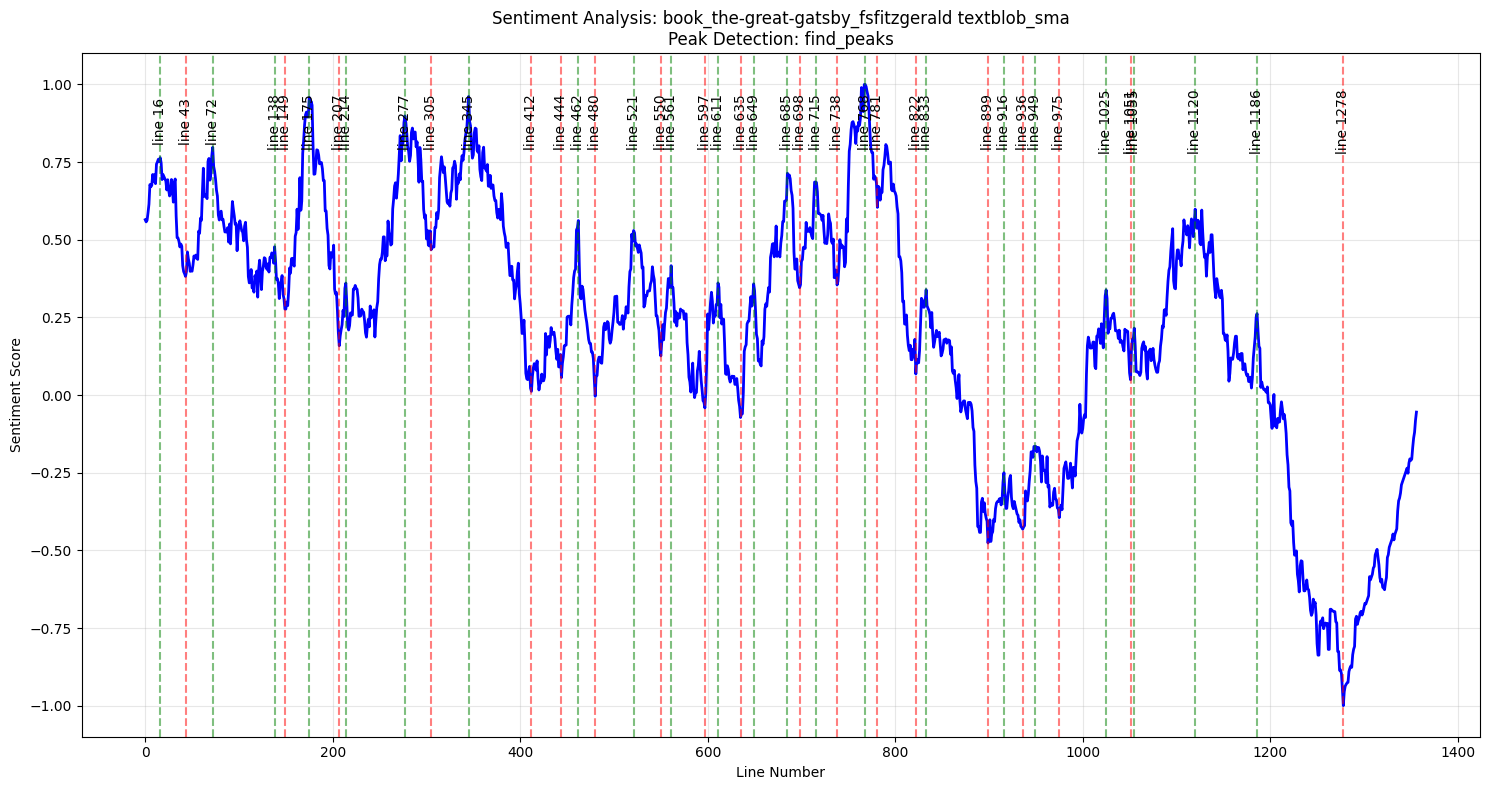

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

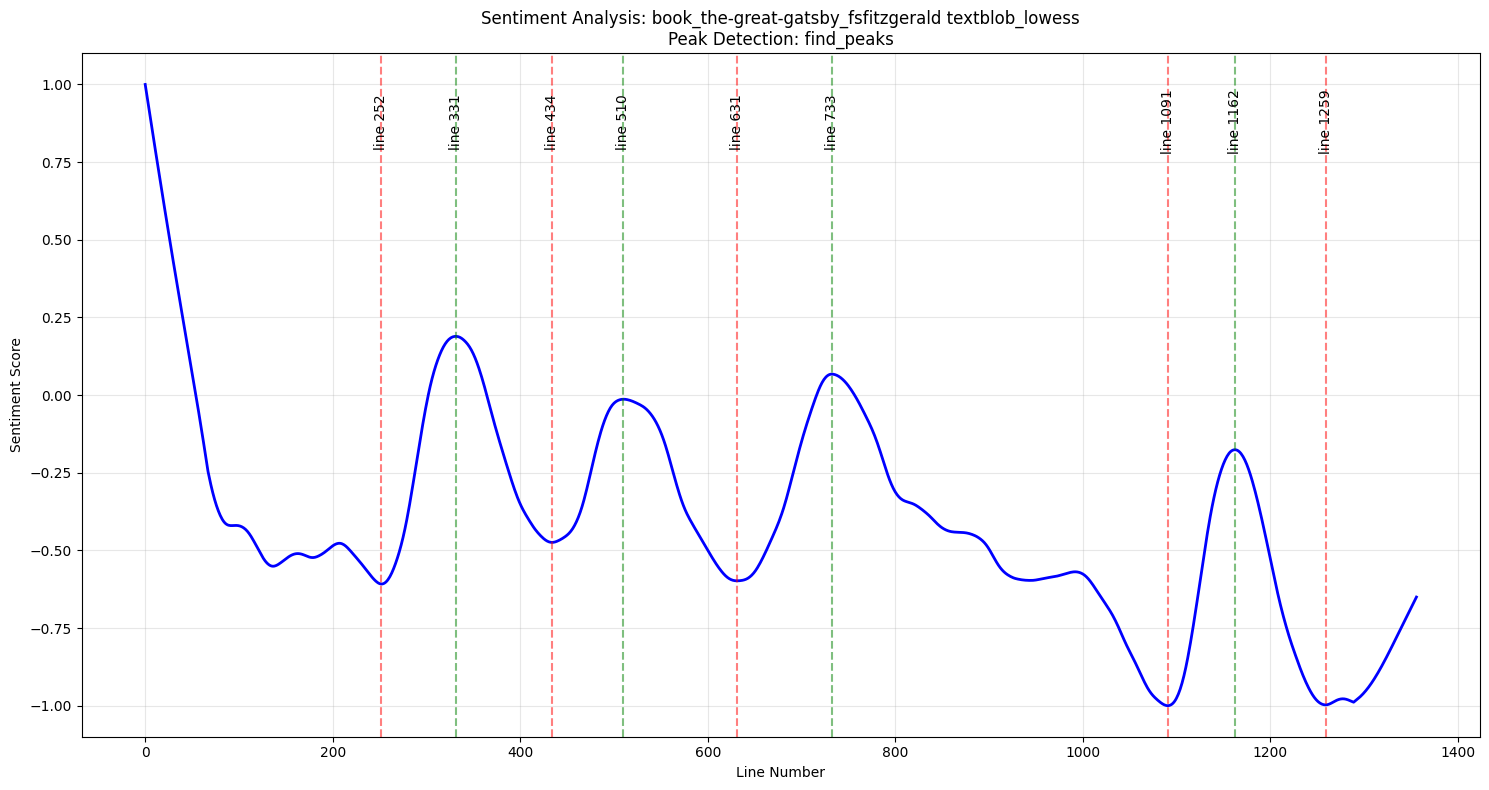

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [263]:
# 2. Create both SMA and LOWESS smoothed versions
smoothed_sma = smooth_ts(sentiment_mean_ls, method='sma', smooth_param=0.1)
smoothed_lowess = smooth_ts(sentiment_mean_ls, method='lowess', smooth_param=0.1)

# 3. Set up peak detection parameters
peak_params = {
    'distance': 30,
    'prominence': 0.15
}

# 4a. Generate and save SMA plot
crux_points_sma, sma_plot_filename = plot_cruxes(
    BOOK_FILENAME_AUTHOR + " " + model_name + "_sma",
    sentiment_mean_ls,
    smoothed_sma,
    peak_algo='find_peaks',
    peak_algo_params=peak_params,
    SIMPLE=True
)

# Download SMA plot
files.download(sma_plot_filename)

# 4b. Generate and save LOWESS plot
crux_points_lowess, lowess_plot_filename = plot_cruxes(
    BOOK_FILENAME_AUTHOR + " " + model_name + "_lowess",
    sentiment_mean_ls,
    smoothed_lowess,
    peak_algo='find_peaks',
    peak_algo_params=peak_params,
    SIMPLE=True
)

# Download LOWESS plot
files.download(lowess_plot_filename)


## Generate Crux Reports

In [267]:
def make_crux_report(book_name, smoothed_series, df, peak_algo='find_peaks', peak_algo_params=None):
    """
    Generate and save formatted report of crux points analysis.
    Uses fixed window size of 21 lines and highlights crux point lines.

    Args:
        book_name (str): Name of the book being analyzed
        smoothed_series (list): Smoothed time series
        df (pd.DataFrame): Input dataframe with text
        peak_algo (str): Peak detection algorithm
        peak_algo_params (dict): Parameters for peak detection
    """
    crux_peaks_text_dt, crux_valleys_text_dt = get_crux_text(
        df, smoothed_series, peak_algo, peak_algo_params, win=21
    )

    report = []

    report.append(f"Sentiment Analysis Crux Points Report for: {book_name}")
    report.append(f"Peak Detection Algorithm: {peak_algo}")
    report.append("Window Size: 21 lines (10 before, CRUX LINE, 10 after)")
    report.append("=" * 80 + "\n")

    report.append("EMOTIONAL PEAKS")
    report.append("-" * 40)
    for line_no, (sentiment, text) in sorted(crux_peaks_text_dt.items()):
        report.append(f"\nPeak at line {line_no} (Sentiment: {sentiment:.3f})")
        report.append("-" * 40)
        wrapped_text = [textwrap.fill(line, width=70) for line in text]
        report.extend(wrapped_text)
        report.append("-" * 40)

    report.append("\nEMOTIONAL VALLEYS")
    report.append("-" * 40)
    for line_no, (sentiment, text) in sorted(crux_valleys_text_dt.items()):
        report.append(f"\nValley at line {line_no} (Sentiment: {sentiment:.3f})")
        report.append("-" * 40)
        wrapped_text = [textwrap.fill(line, width=70) for line in text]
        report.extend(wrapped_text)
        report.append("-" * 40)

    report_text = "\n".join(report)
    report_filename = f"{book_name}_crux_report_{peak_algo}.txt"
    with open(report_filename, "w", encoding="utf-8") as f:
        f.write(report_text)

    print(report_text)
    return report_filename  # Return the filename for use in downloading


In [268]:
# 5. Generate reports for both smoothing methods
from google.colab import files

# 5a. SMA report
sma_report_filename = make_crux_report(
    BOOK_FILENAME_AUTHOR + " " + model_name + "_sma",
    smoothed_sma,
    sentiment_all_df,
    peak_algo='find_peaks',
    peak_algo_params=peak_params
)
# Download SMA report
files.download(sma_report_filename)

# 5b. LOWESS report
lowess_report_filename = make_crux_report(
    BOOK_FILENAME_AUTHOR + " " + model_name + "_lowess",
    smoothed_lowess,
    sentiment_all_df,
    peak_algo='find_peaks',
    peak_algo_params=peak_params
)
# Download LOWESS report
files.download(lowess_report_filename)


Sentiment Analysis Crux Points Report for: book_the-great-gatsby_fsfitzgerald textblob_sma
Peak Detection Algorithm: find_peaks
Window Size: 21 lines (10 before, CRUX LINE, 10 after)

EMOTIONAL PEAKS
----------------------------------------

Peak at line 16 (Sentiment: 0.764)
----------------------------------------
this responsiveness had nothing to do with that flabby
impressionability which is dignified under the name of the "creative
temperament"--it was an extraordinary gift for hope, a romantic
readiness such as i have never found in any other person and which it
is not likely i shall ever find again. no--gatsby turned out all right
at the end; it is what preyed on gatsby, what foul dust floated in the
wake of his dreams that temporarily closed out my interest in the
abortive sorrows and short-winded elations of men.
----------------------------------------------------------------------
-- my family have been prominent, well-to-do people in this middle
western city for three gene

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sentiment Analysis Crux Points Report for: book_the-great-gatsby_fsfitzgerald textblob_lowess
Peak Detection Algorithm: find_peaks
Window Size: 21 lines (10 before, CRUX LINE, 10 after)

EMOTIONAL PEAKS
----------------------------------------

Peak at line 331 (Sentiment: 0.189)
----------------------------------------
"absolutely real--have pages and everything. i thought they'd be a
nice durable cardboard. matter of fact, they're absolutely real. pages
and--here! lemme show you." taking our scepticism for granted, he
rushed to the bookcases and returned with volume one of the stoddard
lectures.
"see!" he cried triumphantly.
"it's a bona-fide piece of printed matter. it fooled me. this fella's
a regular belasco. it's a triumph. what thoroughness! what realism!
knew when to stop, too--didn't cut the pages. but what do you want?
what do you expect?" he snatched the book from me and replaced it
hastily on its shelf, muttering that if one brick was removed the
whole library was liable to

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>